In [45]:
!pip install geojson

/Users/iggy/miniforge3/envs/3-8-10/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
Loading: 100%|██████████| 3224/3224 [00:02<00:00, 1314.19it/s]


data/geocells/admin_1.geojson Size in MegaBytes is 343.82455825805664
Simplified 8817812 polygons to 131494


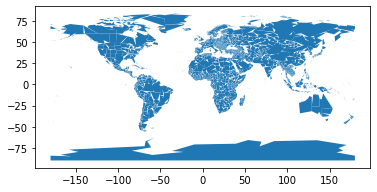

data/geocells/admin_1.geojson_compressed_2.5.geojson Size in MegaBytes is 5.246394157409668


Loading: 100%|██████████| 49349/49349 [00:33<00:00, 1466.65it/s]


data/geocells/admin_2.geojson Size in MegaBytes is 524.9471464157104
Simplified 13153497 polygons to 327604


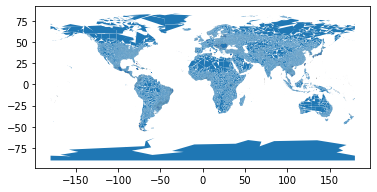

data/geocells/admin_2.geojson_compressed_2.5.geojson Size in MegaBytes is 14.199664115905762


Loading: 100%|██████████| 218/218 [00:00<00:00, 1539.32it/s]


data/geocells/countries.geojson Size in MegaBytes is 382.61291885375977
Simplified 10075273 polygons to 23479


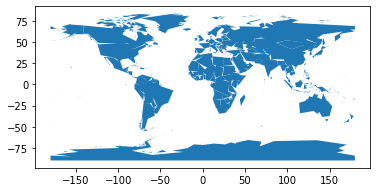

data/geocells/countries.geojson_compressed_2.5.geojson Size in MegaBytes is 0.9441022872924805


In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
import json
from shapely.geometry import shape, GeometryCollection
from geojson import dump
import os
from tqdm import tqdm

# https://stackoverflow.com/questions/56605238/how-to-use-tqdm-for-json-file-load-progress-bar
def hook(obj):
    value = obj.get("features")
    if not value:
        return obj
    pbar = tqdm(value)
    for _ in pbar:
        pbar.set_description(f"Loading")
    return obj


def simplify_geojson(path: str, tolerance: float):
    with open(path) as f:
        features = json.load(f, object_hook=hook)["features"]

    file_stats = os.stat(path)
    print(f'{path} Size in MegaBytes is {file_stats.st_size / (1024 * 1024)}')

    geom = GeometryCollection([shape(feature["geometry"]).buffer(0) for feature in features])
    polys = []
    pre = 0
    post = 0
    for p in geom.geoms:
        poly = p
        if poly.geom_type == 'Polygon':
            x = len(poly.exterior.coords)
        elif poly.geom_type == 'MultiPolygon':
            x = sum([len(poly_item.exterior.coords) for poly_item in poly.geoms])
        pre += x

        poly = poly.simplify(tolerance=tolerance)
        if poly.geom_type == 'Polygon':
            a = len(poly.exterior.coords)
        elif poly.geom_type == 'MultiPolygon':
            a = sum([len(poly_item.exterior.coords) for poly_item in poly.geoms])
        post += a

        polys.append(poly)

    print(f'Simplified {pre} polygons to {post}')
    p = gpd.GeoSeries(polys)
    p.plot()
    plt.show()

    new_filename = f'{path}_compressed_{tolerance}.geojson'
    with open(new_filename, 'w') as f:
        dump(GeometryCollection(polys), f)

    file_stats = os.stat(f'{path}_compressed_{tolerance}.geojson')
    print(f'{new_filename} Size in MegaBytes is {file_stats.st_size / (1024 * 1024)}')

simplify_geojson('data/geocells/admin_1.geojson', 2.5)
simplify_geojson('data/geocells/admin_2.geojson', 2.5)
simplify_geojson('data/geocells/countries.geojson', 2.5)